### **ICU Patient Outcomes – Modeling**

---

**Overview**

This notebook continues the data science workflow for the **ICU Patient Outcomes** project by transitioning from data preparation to predictive and unsupervised modeling. The focus here is on applying statistical and machine learning techniques to predict and understand key hospital outcomes using a fully integrated analytic dataset created prior.

The goal of the modeling phase is to build and evaluate models that can predict ICU length of stay, readmission risk, and mortality, as well as uncover patterns in hospital resource utilization. Each model will be developed, tuned, and interpreted in alignment with the project’s clinical and operational objectives.

---

**Context**

- **Data source:** Analytic dataset derived from the MIMIC-IV Clinical Database Demo (Beth Israel Deaconess Medical Center, curated by MIT LCP).  
- **Scope:** Develop and evaluate supervised and unsupervised learning models for critical ICU outcomes.  
- **Modeling tasks:**
  1. Predict **ICU Length of Stay** (Random Forest Regressor)  
  2. Predict **30-Day Readmission** (Random Forest Classifier)  
  3. Predict **In-Hospital Mortality** (Logistic Regression)  
  4. Identify **Resource Utilization Patterns** (Clustering)

---

**Purpose**

- Translate analytic features into predictive models that address clinical and operational questions.  
- Evaluate model performance using appropriate metrics (e.g., R², ROC-AUC, F1-score).  
- Explore model interpretability through feature importance and coefficients.  
- Perform preliminary model optimization to improve predictive performance.  
- Provide actionable insights that can inform ICU management and patient care strategies.

---

### **Step 0: Import Modules**

The initial code block imports all Python libraries used for this notebook. These include data manipulation, numerical analysis, visualization, modeling, and system utilities for a clean, reproducible workflow.

In [1]:
# Core
import os
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import joblib

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    silhouette_score
)

# Configuration
pd.set_option("display.max_columns", 120)
random_state = 42
np.random.seed(random_state)

In [2]:
# Save directory = the folder this notebook lives in
save_dir = Path(".")
print(f"Models will be saved to: {save_dir.resolve()}")

Models will be saved to: C:\Users\shawn\OneDrive\Documents\PITT MDS\Case Studies in Data Science\ICU_Capstone\notebooks


### **Step 1: Load Data**

---

**Overview**

This step loads the analytic dataset prepared in the previous CRISP-DM phase. Importantly, **the dataset represents one row per hospital admission** and includes key features such as patient demographics, ICU exposure, comorbidities, and outcomes. Before modeling, we perform a quick structural check to confirm that all expected columns, data types, and missing values appear as expected.

---

**Process summary:**

- Define file path and import the analytic dataset  
- Inspect dataset shape and column structure  
- Display a small sample of rows for visual confirmation  

In [3]:
# File path
data_path = "analytic_admissions_dataset.csv"

# Load dataset
df = pd.read_csv(data_path, low_memory=False)

# Basic info
print(f"Shape: {df.shape}")
print("\n--- Column Info ---")
df.info()

# Quick look at first few rows
display(df.head())

Shape: (275, 38)

--- Column Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              275 non-null    int64  
 1   hadm_id                 275 non-null    int64  
 2   admittime               275 non-null    object 
 3   dischtime               275 non-null    object 
 4   deathtime               15 non-null     object 
 5   hospital_expire_flag    275 non-null    int64  
 6   hospital_los_days       275 non-null    float64
 7   readmit_30d_flag        275 non-null    int64  
 8   weekend_admit_flag      275 non-null    int64  
 9   gender                  275 non-null    object 
 10  anchor_age              275 non-null    int64  
 11  age_group               275 non-null    object 
 12  anchor_year             275 non-null    int64  
 13  anchor_year_group       275 non-null    object 
 14  dod 

,subject_id,hadm_id,admittime,dischtime,deathtime,hospital_expire_flag,hospital_los_days,readmit_30d_flag,weekend_admit_flag,gender,anchor_age,age_group,anchor_year,anchor_year_group,dod,ever_in_icu_flag,n_icustays,icu_total_los_days,icu_first_in,icu_last_out,icu_any_multiunit,n_transfers,n_icu_transfers,any_icu_transfer,n_unique_careunits,num_dx,num_icd9,num_icd10,primary_icd_code,primary_icd_version,primary_icd_long_title,admission_type,admission_location,discharge_location,insurance,language,marital_status,race
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,0.79,0,1,F,52,40-64,2180,2014 - 2016,2180-09-09,0,NaN,NaN,NaN,NaN,NaN,3,0,0,3,8,8,0,5723,9,Portal hypertension,Urgent,Transfer From Hospital,Home,Other,English,Widowed,White
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,0,1.02,1,0,F,52,40-64,2180,2014 - 2016,2180-09-09,0,NaN,NaN,NaN,NaN,NaN,3,0,0,3,8,8,0,7071,9,NaN,Ew Emer.,Emergency Room,Home,Medicaid,English,Widowed,White
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,0,2.22,1,1,F,52,40-64,2180,2014 - 2016,2180-09-09,1,1.0,0.410266,2180-07-23 14:00:00,2180-07-23 23:50:47,0.0,6,1,1,4,13,13,0,45829,9,Other iatrogenic hypotension,Ew Emer.,Emergency Room,Home,Medicaid,English,Widowed,White
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,0,1.75,0,1,F,52,40-64,2180,2014 - 2016,2180-09-09,0,NaN,NaN,NaN,NaN,NaN,3,0,0,3,10,10,0,7054,9,NaN,Ew Emer.,Emergency Room,Hospice,Medicaid,English,Widowed,White
4,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaN,0,6.79,1,0,F,55,40-64,2157,2011 - 2013,NaN,1,1.0,1.118032,2157-11-20 19:18:02,2157-11-21 22:08:00,0.0,6,1,1,5,10,10,0,3240,9,Intracranial abscess,Ew Emer.,Emergency Room,Home Health Care,Other,?,Married,White


### **Step 2: Prepare for modeling**

---

**Overview**

Before building predictive models, we need to define our modeling targets and prepare the feature matrix (`X`) and target variables (`y`).  
This step ensures the dataset is ready for each of the three supervised learning tasks:
1. **ICU Length of Stay (LOS)** – regression
2. **30-Day Readmission** – classification
3. **Mortality** – classification

---

**Process summary:**

- Identify and remove ID or text fields not useful for modeling  
- Define target variables (`y_los`, `y_readmit`, `y_mortality`)  
- Create the input feature matrix (`X`) shared across models  
- Verify there are no missing target values  
- Display basic summaries to confirm readiness

In [4]:
# --- Columns to remove (IDs, timestamps, anchors, and text fields) ---
drop_cols = [
    "subject_id", "hadm_id", "admittime", "dischtime", "deathtime",
    "anchor_year", "anchor_year_group", "dod",
    "primary_icd_code", "primary_icd_version", "primary_icd_long_title",
    "icu_first_in", "icu_last_out"
]

# --- Define target variables ---
target_los = "icu_total_los_days"
target_readmit = "readmit_30d_flag"
target_mortality = "hospital_expire_flag"

# --- Ensure target columns exist before dropping ---
for t in [target_los, target_readmit, target_mortality]:
    if t not in df.columns:
        raise ValueError(f"Missing target column: {t}")

# --- Drop the unneeded columns ---
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

# --- Define feature matrix and targets ---
X = df_model.drop(columns=[target_los, target_readmit, target_mortality])
y_los = df_model[target_los]
y_readmit = df_model[target_readmit]
y_mortality = df_model[target_mortality]

# --- Confirm shapes and missingness ---
print("Feature matrix shape:", X.shape)
print("LOS target shape:", y_los.shape)
print("Readmission target shape:", y_readmit.shape)
print("Mortality target shape:", y_mortality.shape)

print("\nMissing targets:")
print({
    "LOS": y_los.isna().sum(),
    "Readmission": y_readmit.isna().sum(),
    "Mortality": y_mortality.isna().sum()
})

Feature matrix shape: (275, 22)
LOS target shape: (275,)
Readmission target shape: (275,)
Mortality target shape: (275,)

Missing targets:
{'LOS': np.int64(147), 'Readmission': np.int64(0), 'Mortality': np.int64(0)}


In [5]:
# Check remaining missing values in features
print("\n--- Missing Values in Features ---")
missing_features = X.isna().sum().sort_values(ascending=False)
print(missing_features[missing_features > 0].head(10))

# Quick distribution checks for classification targets
print("\n--- Target Distributions ---")
print("Readmission value counts:\n", y_readmit.value_counts(normalize=True).round(3))
print("\nMortality value counts:\n", y_mortality.value_counts(normalize=True).round(3))


--- Missing Values in Features ---
icu_any_multiunit    147
n_icustays           147
dtype: int64

--- Target Distributions ---
Readmission value counts:
 readmit_30d_flag
0    0.807
1    0.193
Name: proportion, dtype: float64

Mortality value counts:
 hospital_expire_flag
0    0.945
1    0.055
Name: proportion, dtype: float64


### **Step 3: Model 1 – Predict ICU Length of Stay (Random Forest Regressor)**

---

**Overview**

This section builds a regression model to predict **ICU Length of Stay (LOS)** using patient and admission features and a **Random Forest Regressor**, which performs well on nonlinear relationships and mixed data types. Importantly, because many admissions were never in the ICU, we’ll first filter to include only cases where `ever_in_icu_flag == 1` and where `icu_total_los_days` is not missing.

---

**Process summary**

1. Filter dataset to include only ICU admissions with a valid LOS value  
2. Split data into training, validation, and testing sets (70/15/15)  
3. Build a simple preprocessing pipeline (impute missing values, one-hot encode categorical variables)  
4. Train a baseline Random Forest Regressor
5. Evaluate model performance (R², MAE, RMSE)  
6. Perform a quick parameter search for basic optimization

In [6]:
# --- Step 3.1: Filter for valid ICU records ---
df_los = df_model[df_model["ever_in_icu_flag"] == 1].copy()
df_los = df_los[df_los["icu_total_los_days"].notna()]
print(f"Filtered ICU admissions: {df_los.shape[0]} rows")

Filtered ICU admissions: 128 rows


In [7]:
# --- Step 3.2: Define features and target ---
X_los = df_los.drop(columns=[target_los, target_readmit, target_mortality])
y_los = df_los[target_los]

In [8]:
# --- Step 3.3: Split into train / validation / test (70 / 15 / 15) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_los, y_los, test_size=0.30, random_state=random_state
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=random_state
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (89, 22), Validation: (19, 22), Test: (20, 22)


In [9]:
# --- Step 3.4: Identify numeric and categorical columns ---
numeric_features = X_los.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_los.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [10]:
# --- Step 3.5: Preprocessing pipeline ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
# --- Step 3.6: Build pipeline with Random Forest ---
rf_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=random_state))
])

In [12]:
# --- Step 3.7: Train baseline model ---
rf_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hospital_los_days',
                                                   'weekend_admit_flag',
                                                   'anchor_age',
                                                   'ever_in_icu_flag',
                                                   'n_icustays',
                                                   'icu_any_multiunit',
                                                   'n_transfers',
                                                   'n_icu_transfers',
                                                   'any_icu_transfer',
                                                   'n_unique_careunits',
                                                   'num_dx', 'num_icd9',
                                                   'num_icd10']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'age_group',
                                                   'admission_type',
                                                   'admission_location',
                                                   'discharge_location',
                                                   'insurance', 'language',
                                                   'marital_status',
                                                   'race'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [13]:
# --- Step 3.8: Evaluate on validation set ---
y_val_pred = rf_reg.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("\n--- Baseline Random Forest Regressor (Validation) ---")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


--- Baseline Random Forest Regressor (Validation) ---
R²: 0.636
MAE: 2.13
RMSE: 3.17


In [14]:
# --- Step 3.9: Quick optimization using GridSearchCV (on training + validation) ---

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

grid = GridSearchCV(rf_reg, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest parameters:", grid.best_params_)
print(f"Best CV R²: {grid.best_score_:.3f}")


Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best CV R²: 0.273


In [15]:
# --- Step 3.10: Final evaluation on test set ---
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)
print("\n--- Final Test Performance ---")
print(f"Test R²: {r2_score(y_test, y_test_pred):.3f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")


--- Final Test Performance ---
Test R²: 0.712
Test MAE: 2.11
Test RMSE: 2.82


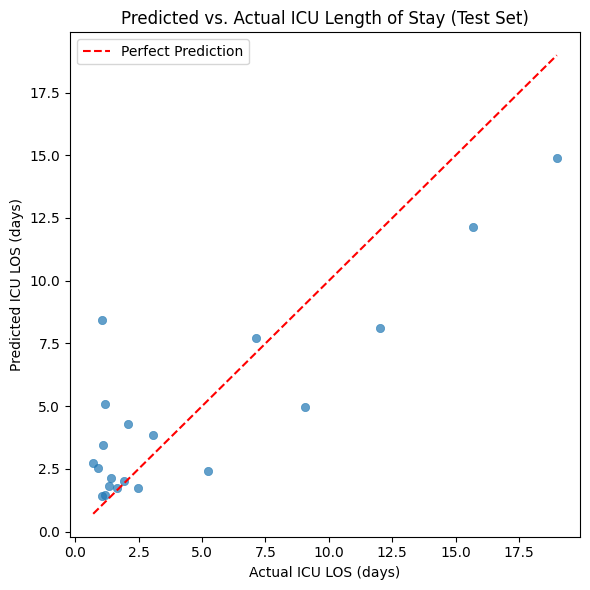

In [16]:
# --- Step 3.11: Visualize predicted vs. actual ICU LOS ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7, edgecolor=None)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual ICU LOS (days)")
plt.ylabel("Predicted ICU LOS (days)")
plt.title("Predicted vs. Actual ICU Length of Stay (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

,feature,importance
0,hospital_los_days,0.561794
10,num_dx,0.069175
12,num_icd10,0.068657
35,discharge_location_Died,0.044408
7,n_icu_transfers,0.030906
6,n_transfers,0.030265
2,anchor_age,0.028331
5,icu_any_multiunit,0.024266
43,insurance_Medicare,0.010813
41,discharge_location_Skilled Nursing Facility,0.010347


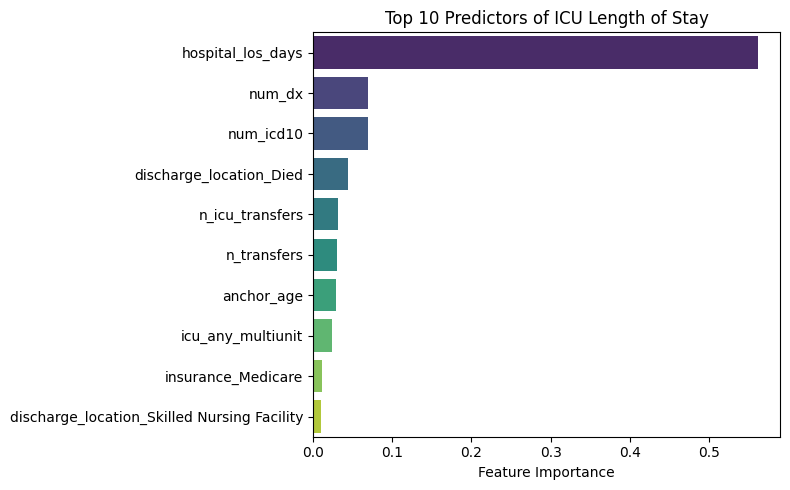

In [17]:
# --- Step 3.12: Feature importance extraction ---

# Get the trained RandomForestRegressor from pipeline
rf_model = best_model.named_steps["model"]

# Get one-hot encoded feature names
cat_features = list(best_model.named_steps["preprocessor"]
                    .named_transformers_["cat"]
                    .named_steps["encoder"]
                    .get_feature_names_out(categorical_features))

all_features = numeric_features + cat_features

# Combine importances
importances = pd.DataFrame({
    "feature": all_features,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

# Display top 10 predictors
display(importances.head(10))

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importances.head(10), x="importance", y="feature", palette="viridis")
plt.title("Top 10 Predictors of ICU Length of Stay")
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [18]:
# --- Step 3.13: Focused optimization (simplified version) ---

# Use the full X_los but with smarter parameter grid
X_los_top = X_los.copy()
X_train_top, X_temp_top, y_train_top, y_temp_top = train_test_split(
    X_los_top, y_los, test_size=0.30, random_state=random_state
)
X_val_top, X_test_top, y_val_top, y_test_top = train_test_split(
    X_temp_top, y_temp_top, test_size=0.50, random_state=random_state
)

# Reuse numeric/categorical splits and preprocessors
preprocessor_top = preprocessor  # reuse previous transformer setup

rf_top = Pipeline(steps=[
    ("preprocessor", preprocessor_top),
    ("model", RandomForestRegressor(random_state=random_state))
])

# Expanded grid for fine tuning
param_grid_top = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["auto", "sqrt"]
}

grid_top = GridSearchCV(rf_top, param_grid_top, cv=3, scoring="r2", n_jobs=-1)
grid_top.fit(X_train_top, y_train_top)

print("\nBest parameters (refined model):", grid_top.best_params_)
print(f"Best CV R²: {grid_top.best_score_:.3f}")

# Evaluate refined model
best_top_model = grid_top.best_estimator_
y_test_pred_top = best_top_model.predict(X_test_top)
print("\n--- Final Test Performance (Refined Model) ---")
print(f"Test R²: {r2_score(y_test_top, y_test_pred_top):.3f}")
print(f"Test MAE: {mean_absolute_error(y_test_top, y_test_pred_top):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_top, y_test_pred_top)):.2f}")


Best parameters (refined model): {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV R²: 0.272

--- Final Test Performance (Refined Model) ---
Test R²: 0.562
Test MAE: 2.48
Test RMSE: 3.47


In [19]:
# --- Step 3.14: Save final ICU LOS Random Forest model ---

los_model_path = save_dir / "los_random_forest.pkl"
joblib.dump(best_top_model, los_model_path)

print(f"LOS model saved to: {los_model_path.resolve()}")

LOS model saved to: C:\Users\shawn\OneDrive\Documents\PITT MDS\Case Studies in Data Science\ICU_Capstone\notebooks\los_random_forest.pkl


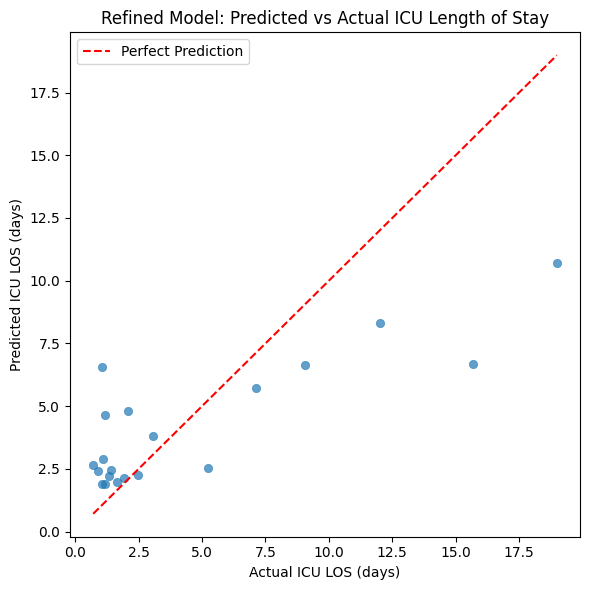

In [20]:
# --- Step 3.15: Visualize refined model predictions vs actuals ---

# Generate predictions for the test set
y_test_pred_top = best_top_model.predict(X_test_top)

# Plot predicted vs actual ICU LOS
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_top, y=y_test_pred_top, alpha=0.7, edgecolor=None)
plt.plot([y_test_top.min(), y_test_top.max()],
         [y_test_top.min(), y_test_top.max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual ICU LOS (days)")
plt.ylabel("Predicted ICU LOS (days)")
plt.title("Refined Model: Predicted vs Actual ICU Length of Stay")
plt.legend()
plt.tight_layout()
plt.show()

### **Step 4: Model 2 – Predict 30-Day Readmission (Random Forest Classifier)**

---

**Overview**

In this step, we will build a **classification model** to predict whether a patient is readmitted to the hospital within 30 days of discharge. This model supports the hospital’s quality and resource-planning objectives by identifying patients at higher risk of short-term readmission. Importantly, we’ll use a **Random Forest Classifier** to capture nonlinear patterns and interactions among clinical and demographic variables.

---

**Process summary**

1. Filter the dataset to admissions with valid `readmit_30d_flag` values  
2. Split into training, validation, and test sets (70 / 15 / 15)  
3. Apply the same preprocessing pipeline (imputation + encoding + scaling)  
4. Train a baseline Random Forest Classifier  
5. Evaluate performance with key classification metrics  
6. Perform a quick hyperparameter optimization and reassess performance  

In [21]:
# --- Step 4.1: Filter for valid readmission records ---
df_readmit = df_model[df_model["readmit_30d_flag"].notna()].copy()
print(f"Valid admissions for readmission modeling: {df_readmit.shape[0]} rows")

Valid admissions for readmission modeling: 275 rows


In [22]:
# --- Step 4.2: Define features and target ---
X_readmit = df_readmit.drop(columns=[target_los, target_readmit, target_mortality])
y_readmit = df_readmit[target_readmit]

In [23]:
# --- Step 4.3: Split data (70/15/15) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_readmit, y_readmit, test_size=0.30, stratify=y_readmit, random_state=random_state
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=random_state
)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (192, 22), Validation: (41, 22), Test: (42, 22)


In [24]:
# --- Step 4.4: Reuse numeric & categorical features ---
numeric_features = X_readmit.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_readmit.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [25]:
# --- Step 4.5: Reuse preprocessing pipeline ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [26]:
# --- Step 4.6: Build pipeline with Random Forest Classifier ---
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=random_state, class_weight="balanced"))
])

In [27]:
# --- Step 4.7: Train baseline model ---
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hospital_los_days',
                                                   'weekend_admit_flag',
                                                   'anchor_age',
                                                   'ever_in_icu_flag',
                                                   'n_icustays',
                                                   'icu_any_multiunit',
                                                   'n_transfers',
                                                   'n_icu_transfers',
                                                   'any_icu_transfer',
                                                   'n_unique_careunits',
                                                   'num_dx',...
                                                   'num_icd10']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'age_group',
                                                   'admission_type',
                                                   'admission_location',
                                                   'discharge_location',
                                                   'insurance', 'language',
                                                   'marital_status',
                                                   'race'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [28]:
# --- Step 4.8: Evaluate baseline on validation set ---
y_val_pred = rf_clf.predict(X_val)
y_val_proba = rf_clf.predict_proba(X_val)[:, 1]

print("\n--- Baseline Random Forest Classifier (Validation) ---")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba):.3f}")


--- Baseline Random Forest Classifier (Validation) ---
Accuracy: 0.805
Precision: 0.500
Recall: 0.125
F1 Score: 0.200
ROC AUC: 0.758


In [29]:
# --- Step 4.9: Quick parameter optimization ---
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(rf_clf, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest parameters:", grid.best_params_)
print(f"Best CV ROC AUC: {grid.best_score_:.3f}")


Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV ROC AUC: 0.460


In [30]:
# --- Step 4.10: Final test evaluation ---
best_clf = grid.best_estimator_
y_test_pred = best_clf.predict(X_test)
y_test_proba = best_clf.predict_proba(X_test)[:, 1]

print("\n--- Final Test Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.3f}")


--- Final Test Performance ---
Accuracy: 0.810
Precision: 0.500
Recall: 0.125
F1 Score: 0.200
ROC AUC: 0.739


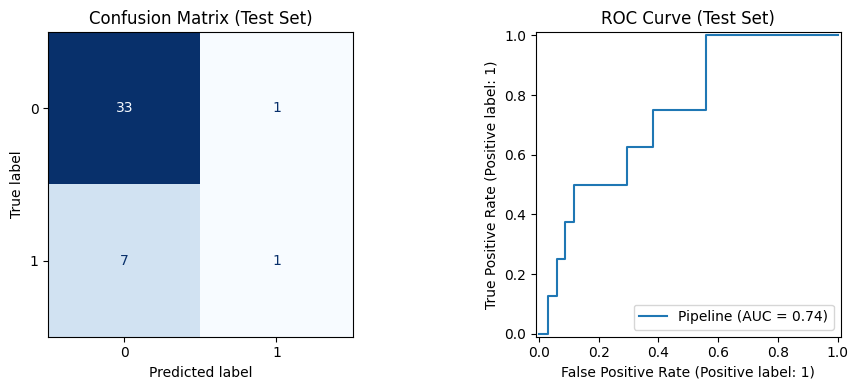

In [31]:
# --- Step 4.11: Visualize model performance ---

# Confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Confusion Matrix (Test Set)")

# ROC curve
RocCurveDisplay.from_estimator(best_clf, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve (Test Set)")

plt.tight_layout()
plt.show()

### **Step 5: Model 3 – Predict In-Hospital Mortality (Logistic Regression)**

---

**Overview**

This step develops a **Logistic Regression** model to predict **in-hospital mortality**, a critical clinical outcome that can inform risk assessment and care prioritization. Unlike tree-based models, logistic regression provides interpretable coefficients (odds ratios), allowing direct insight into which features increase or decrease mortality risk.

---

**Process summary**

1. Filter data to admissions with valid mortality flags  
2. Split data into training, validation, and test sets (70 / 15 / 15)  
3. Use the same preprocessing pipeline (imputation + scaling + encoding)  
4. Train a baseline Logistic Regression model  
5. Evaluate performance with classification metrics and ROC AUC  
6. Interpret coefficients to identify key mortality predictors

In [32]:
# --- Step 5.1: Filter for valid mortality records ---
df_mort = df_model[df_model["hospital_expire_flag"].notna()].copy()
print(f"Valid admissions for mortality modeling: {df_mort.shape[0]} rows")

Valid admissions for mortality modeling: 275 rows


In [33]:
# --- Step 5.2: Define features and target ---
X_mort = df_mort.drop(columns=[target_los, target_readmit, target_mortality])
y_mort = df_mort[target_mortality]

In [34]:
# --- Step 5.3: Split data (70/15/15) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_mort, y_mort, test_size=0.30, stratify=y_mort, random_state=random_state
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=random_state
)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (192, 22), Validation: (41, 22), Test: (42, 22)


In [35]:
# --- Step 5.4: Reuse numeric & categorical preprocessing ---
numeric_features = X_mort.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_mort.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [36]:
# --- Step 5.5: Build Logistic Regression pipeline ---
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        random_state=random_state,
        max_iter=1000,
        solver="liblinear",
        class_weight="balanced"
    ))
])

In [37]:
# --- Step 5.6: Train baseline model ---
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hospital_los_days',
                                                   'weekend_admit_flag',
                                                   'anchor_age',
                                                   'ever_in_icu_flag',
                                                   'n_icustays',
                                                   'icu_any_multiunit',
                                                   'n_transfers',
                                                   'n_icu_transfers',
                                                   'any_icu_transfer',
                                                   'n_unique_careunits',
                                                   'num_dx',...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'age_group',
                                                   'admission_type',
                                                   'admission_location',
                                                   'discharge_location',
                                                   'insurance', 'language',
                                                   'marital_status',
                                                   'race'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

In [38]:
# --- Step 5.7: Evaluate on validation set ---
y_val_pred = log_reg.predict(X_val)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]

print("\n--- Baseline Logistic Regression (Validation) ---")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba):.3f}")


--- Baseline Logistic Regression (Validation) ---
Accuracy: 0.976
Precision: 0.667
Recall: 1.000
F1 Score: 0.800
ROC AUC: 1.000


In [39]:
# --- Step 5.8: Final evaluation on test set ---
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)[:, 1]

print("\n--- Final Test Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.3f}")


--- Final Test Performance ---
Accuracy: 0.929
Precision: 0.500
Recall: 0.667
F1 Score: 0.571
ROC AUC: 0.966


In [40]:
# --- Step 5.9: Save final mortality Logistic Regression model ---

mortality_model_path = save_dir / "mortality_logreg.pkl"
joblib.dump(log_reg, mortality_model_path)

print(f"Mortality model saved to: {mortality_model_path.resolve()}")

Mortality model saved to: C:\Users\shawn\OneDrive\Documents\PITT MDS\Case Studies in Data Science\ICU_Capstone\notebooks\mortality_logreg.pkl


,feature,coefficient,odds_ratio
41,discharge_location_Died,2.593022,13.370111
10,num_dx,0.952044,2.591000
3,ever_in_icu_flag,0.721157,2.056812
4,n_icustays,0.649303,1.914205
12,num_icd10,0.539038,1.714357
54,marital_status_Married,0.437011,1.548074
8,any_icu_transfer,0.308211,1.360988
5,icu_any_multiunit,0.280556,1.323866
2,anchor_age,0.269269,1.309007
11,num_icd9,0.267422,1.306592


,feature,coefficient,odds_ratio
57,marital_status_Widowed,-0.441585,0.643017
50,insurance_Other,-0.463739,0.628928
58,race_Black/African American,-0.487902,0.613913
13,gender_F,-0.540649,0.582370
0,hospital_los_days,-0.629419,0.532902
16,age_group_40-64,-0.655559,0.519152
42,discharge_location_Home,-0.662361,0.515632
52,language_English,-0.912345,0.401581
43,discharge_location_Home Health Care,-0.934268,0.392873
46,discharge_location_Skilled Nursing Facility,-0.966588,0.380379


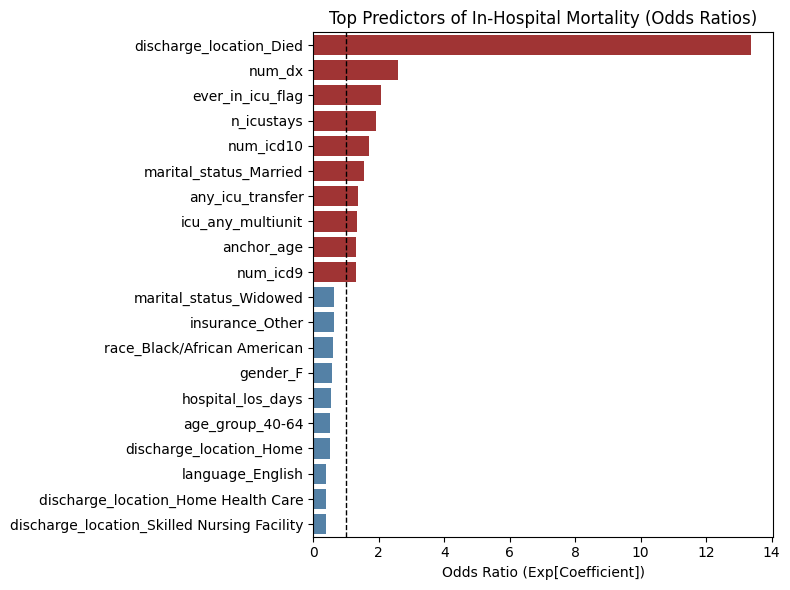

In [41]:
# --- Step 5.10: Extract and interpret coefficients ---

# Get trained logistic regression model
log_model = log_reg.named_steps["model"]

# Get encoded feature names
cat_features = list(log_reg.named_steps["preprocessor"]
                    .named_transformers_["cat"]
                    .named_steps["encoder"]
                    .get_feature_names_out(categorical_features))
all_features = numeric_features + cat_features

# Build dataframe of coefficients
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": log_model.coef_[0]
})
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df = coef_df.sort_values("odds_ratio", ascending=False)

# Display top and bottom predictors
display(coef_df.head(10))
display(coef_df.tail(10))

# --- Plot top positive and negative predictors ---
top_features = pd.concat([coef_df.head(10), coef_df.tail(10)])

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_features,
    x="odds_ratio", y="feature",
    palette=["firebrick" if x > 1 else "steelblue" for x in top_features["odds_ratio"]]
)
plt.axvline(1, color="black", linestyle="--", linewidth=1)
plt.title("Top Predictors of In-Hospital Mortality (Odds Ratios)")
plt.xlabel("Odds Ratio (Exp[Coefficient])")
plt.ylabel("")
plt.tight_layout()
plt.show()

### **Step 6: Model 4 – Resource Allocation Clustering (K-Means)**

---

**Overview**

This final modeling task uses **unsupervised learning** to identify patterns in hospital resource utilization across admissions. By clustering similar admissions, we can uncover groups that differ in ICU exposure, number of transfers, length of stay, or diagnosis complexity - helping inform better capacity planning and resource allocation. We’ll use **K-Means clustering**, a simple but powerful method for partitioning admissions into distinct utilization profiles.

---

**Process summary**

1. Select key utilization-related features (e.g., hospital LOS, ICU exposure, transfers, diagnoses)  
2. Standardize numeric variables for fair clustering  
3. Use the **Elbow Method** and **Silhouette Score** to select the optimal number of clusters  
4. Fit K-Means and label clusters  
5. Profile each cluster to understand their resource usage patterns  

In [42]:
# --- Step 6.1: Select clustering features ---
cluster_features = [
    "hospital_los_days", "ever_in_icu_flag", "n_icustays", "icu_total_los_days",
    "n_transfers", "n_icu_transfers", "any_icu_transfer", "n_unique_careunits",
    "num_dx", "num_icd9", "num_icd10"
]

df_cluster = df_model[cluster_features].copy().dropna()
print(f"Records used for clustering: {df_cluster.shape[0]}")

Records used for clustering: 128


In [43]:
# --- Step 6.2: Scale features ---
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(df_cluster)

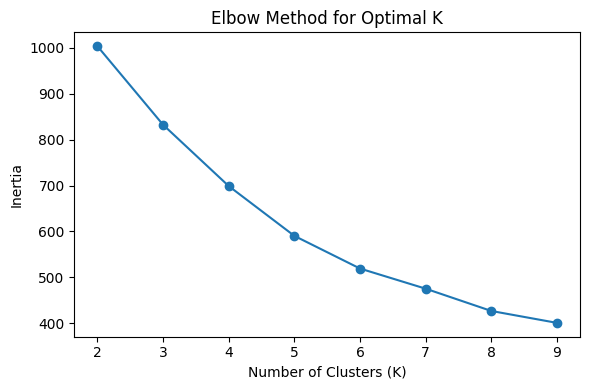

In [44]:
# --- Step 6.3: Determine optimal number of clusters (Elbow Method) ---
inertias = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

In [45]:
# --- Step 6.4: Silhouette score evaluation ---
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, labels)
    print(f"K={k}: Silhouette Score = {score:.3f}")

K=2: Silhouette Score = 0.347
K=3: Silhouette Score = 0.312
K=4: Silhouette Score = 0.356
K=5: Silhouette Score = 0.337
K=6: Silhouette Score = 0.264


In [46]:
# --- Step 6.5: Fit final K-Means model (K=4) ---
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
df_cluster["cluster"] = kmeans_final.fit_predict(X_cluster_scaled)

In [47]:
# --- Step 6.6: Save final K-Means model pipeline ---

cluster_pipeline = Pipeline([
    ("scaler", scaler),
    ("model", kmeans_final)
])

cluster_model_path = save_dir / "kmeans_clusters.pkl"
joblib.dump(cluster_pipeline, cluster_model_path)

print(f"Clustering model saved to: {cluster_model_path.resolve()}")

Clustering model saved to: C:\Users\shawn\OneDrive\Documents\PITT MDS\Case Studies in Data Science\ICU_Capstone\notebooks\kmeans_clusters.pkl


In [48]:
# --- Step 6.7: Summarize cluster profiles ---
cluster_summary = (
    df_cluster.groupby("cluster")
    .agg(["mean", "std", "count"])
    .round(2)
)
display(cluster_summary)

hospital_los_days             ever_in_icu_flag            n_icustays  \
                     mean   std count             mean  std count       mean   
cluster                                                                        
0                    6.09  3.85    80              1.0  0.0    80       1.01   
1                   13.86  8.83    23              1.0  0.0    23       1.09   
2                    9.07  5.72     9              1.0  0.0     9       1.11   
3                   17.96  9.34    16              1.0  0.0    16       1.50   

                    icu_total_los_days             n_transfers              \
          std count               mean   std count        mean   std count   
cluster                                                                      
0        0.11    80               2.02  1.35    80        4.62  1.18    80   
1        0.29    23               6.97  5.92    23        5.13  1.36    23   
2        0.33     9               5.48  5.02     9        4.00  1.12     9   
3        0.89    16               9.00  5.48    16        7.06  2.05    16   

        n_icu_transfers             any_icu_transfer             \
                   mean   std count             mean  std count   
cluster                                                           
0                  1.14  0.41    80              1.0  0.0    80   
1                  1.48  0.59    23              1.0  0.0    23   
2                  0.00  0.00     9              0.0  0.0     9   
3                  1.88  1.09    16              1.0  0.0    16   

        n_unique_careunits             num_dx              num_icd9        \
                      mean   std count   mean    std count     mean   std   
cluster                                                                     
0                     3.95  0.69    80  12.65   5.99    80     9.52  7.70   
1                     4.57  1.20    23  29.22   6.37    23     0.00  0.00   
2                     3.56  0.73     9  22.67  10.11     9     1.22  3.67   
3                     4.44  1.03    16  27.56   8.11    16    27.56  8.11   

              num_icd10               
        count      mean    std count  
cluster                               
0          80      3.12   6.08    80  
1          23     29.22   6.37    23  
2           9     21.44  12.16     9  
3          16      0.00   0.00    16

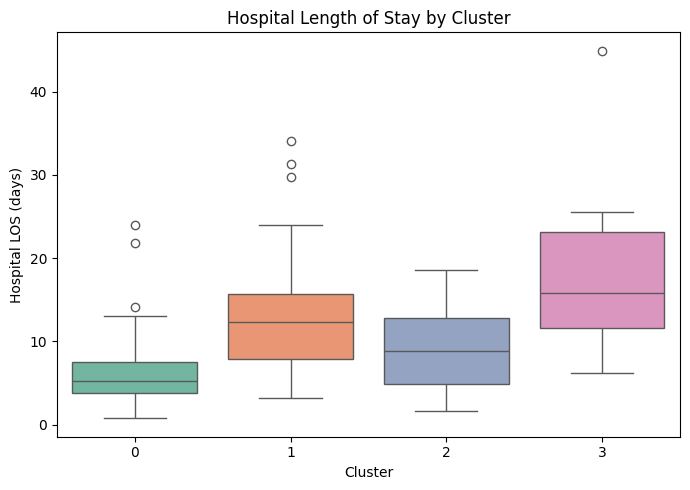

In [49]:
# --- Step 6.7: Visualize distribution of hospital LOS by cluster ---
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_cluster, x="cluster", y="hospital_los_days", palette="Set2")
plt.title("Hospital Length of Stay by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Hospital LOS (days)")
plt.tight_layout()
plt.show()

In [50]:
# --- Step 6.8: Inspect average ICU utilization per cluster ---
icu_cols = ["ever_in_icu_flag", "icu_total_los_days", "n_icustays", "n_icu_transfers"]
display(df_cluster.groupby("cluster")[icu_cols].mean().round(2))

,ever_in_icu_flag,icu_total_los_days,n_icustays,n_icu_transfers
cluster,,,,
0,1.0,2.02,1.01,1.14
1,1.0,6.97,1.09,1.48
2,1.0,5.48,1.11,0.00
3,1.0,9.00,1.50,1.88
